In [640]:
import os
import cv2
import random
import numpy as np 
from matplotlib import pyplot as plt


In [641]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Dense, Input, Flatten
import tensorflow as tf


In [642]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    

In [643]:
# import os
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw',directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)
        

In [644]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [645]:
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [646]:
# !tar -xf lfw.tgz

In [647]:
# import os
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw',directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)
        

In [648]:
import uuid
uuid.uuid1()

UUID('273073b2-5159-11ef-92fb-8a72950b89b0')

In [649]:
# os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

In [650]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()

    
    frame = cv2.resize(frame, (500,250))
    frame = frame[0:0+250,:250,:]
    if cv2.waitKey(1) & 0XFF == ord('a'):
     
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    if cv2.waitKey(1) & 0XFF == ord('p'):

        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    cv2.imshow('Image Collection', frame)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

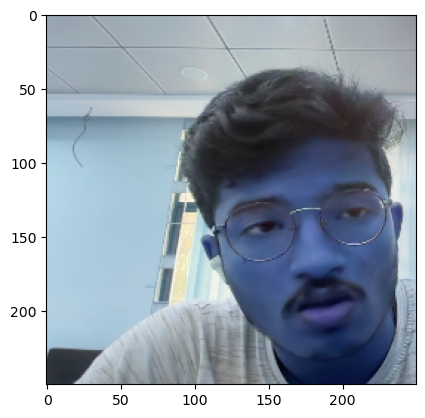

In [651]:
plt.imshow(frame[:250,:250,:])

In [652]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(500)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(500)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(500)

In [653]:
dir_test = anchor.as_numpy_iterator()

In [654]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [655]:
# dataset.map(preprocess)

In [656]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [657]:
samples = data.as_numpy_iterator()

In [658]:
example = samples.next()

In [659]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [660]:
res = preprocess_twin(*example)

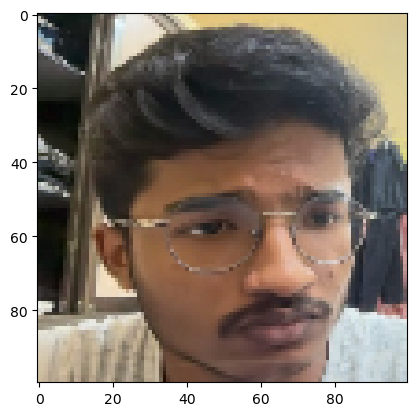

In [661]:
plt.imshow(res[1])

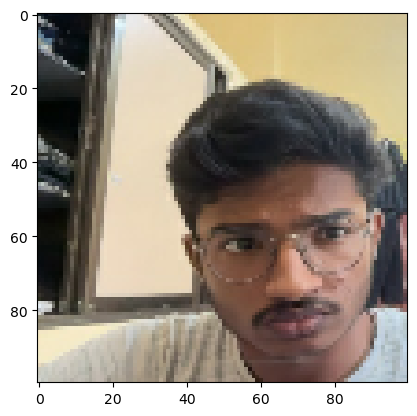

In [662]:
plt.imshow(res[0])

In [663]:
res[2]

1.0

In [664]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [665]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [666]:
train_samples = train_data.as_numpy_iterator()

In [667]:
train_samples = train_samples.next()

In [668]:
len(train_samples[0])

16

In [669]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [670]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [671]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [672]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [673]:
embedding = make_embedding()

In [674]:
embedding.summary()


Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [675]:
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, input_embedding, validation_embedding):
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [676]:
l1 = L1Dist()

In [677]:
l1

<L1Dist name=l1_dist_21, built=False>

In [678]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [679]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [680]:
inp_embedding

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_238>]

In [681]:
val_embedding

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_239>]

In [682]:
siamese_layer = L1Dist()

In [683]:
siamese_layer(inp_embedding,val_embedding)

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_240>

In [684]:
def make_siamese_model(): 

    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [685]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_22 (L1Dist) │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │      4,097 │ l1_dist_22[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [686]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [687]:
opt = tf.keras.optimizers.Adam(1e-4) 

In [688]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [689]:
test_batch = train_data.as_numpy_iterator()

In [690]:
batch_1 = test_batch.next()

In [691]:
X = batch_1[:2]
y = batch_1[2]

In [692]:
y

array([0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

In [693]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
    dtype=None,
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](htt

In [694]:
@tf.function
def train_step(batch):
     
    with tf.GradientTape() as tape:     
        X = batch[:2]
        y = batch[2]

        yhat = siamese_model(X, training=True)
        yhat = tf.squeeze(yhat)  
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [695]:
from tensorflow.keras.metrics import Precision, Recall

In [696]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
      
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            progbar.update(idx+1)
        

        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [697]:
EPOCHS = 50

In [698]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
43/44 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepTensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
44/44 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step

 Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step

 Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step

 Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 210s 5s/step

 Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 183s 4s/step

 Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step

 Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 210s 5s/step

 Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step

 Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step

 Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step

 Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step

 Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step

 Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 216s 5s/step

 Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 209s 5s/step

 Epoch 15/50
44/44 ━━━━━━━━━━

In [699]:
from tensorflow.keras.metrics import Precision, Recall

In [700]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [701]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat = y_hat[0]
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[1.2621222e-17],
       [1.0000000e+00],
       [1.0000000e+00],
       [7.6647355e-09],
       [1.0000000e+00],
       [8.8239506e-07],
       [3.2784185e-11],
       [1.0000000e+00],
       [9.9999756e-01],
       [9.9971801e-01],
       [3.2262776e-16],
       [1.7798912e-13],
       [2.2314637e-12],
       [9.9279958e-01],
       [3.8211287e-15],
       [1.2782509e-08]], dtype=float32)

In [702]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0]

In [703]:
y_true

array([0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

In [704]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [705]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [706]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1.0 1.0


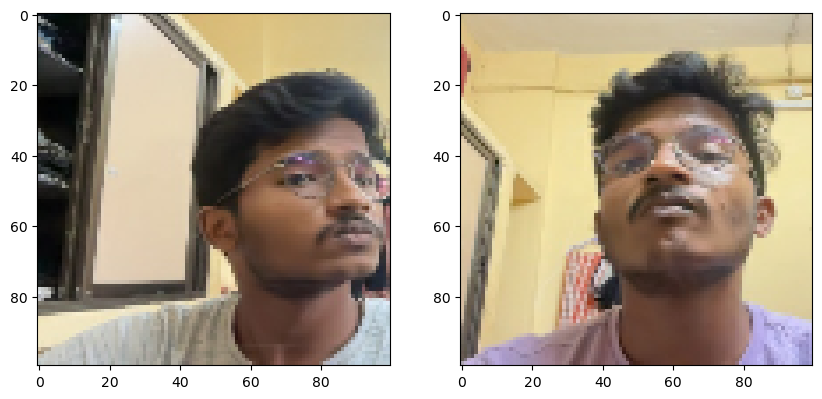

In [707]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

In [708]:
siamese_model.save('siamesemodelv2.h5')

In [709]:
L1Dist

__main__.L1Dist

In [710]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [711]:
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[[9.9909127e-01],
        [1.0000000e+00],
        [1.0000000e+00],
        [2.7134772e-13],
        [2.7971744e-16],
        [5.4316060e-06],
        [9.9997222e-01],
        [9.9991840e-01],
        [1.0000000e+00],
        [9.8910153e-01],
        [9.9871176e-01]]], dtype=float32)

In [712]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_23 (L1Dist) │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │      4,097 │ l1_dist_23[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [713]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [716]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame = cap.read()
  frame = cv2.resize(frame, (500,250))
  frame = frame[:250,:250,:]

  cv2.imshow('verification', frame)

  if cv2.waitKey(10) & 0xFF == ord('v'):
    cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)

    results, verified = verify(siamese_model, 0.9, 0.7)
    print(verified)
  

  if cv2.waitKey(10) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# import os
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw',directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)
        

In [718]:
np.sum(np.squeeze(results) > 0.9)

6

In [719]:
results

[array([[[0.88654447]]], dtype=float32),
 array([[[8.763235e-05]]], dtype=float32),
 array([[[0.9997703]]], dtype=float32),
 array([[[0.00129344]]], dtype=float32),
 array([[[0.9973767]]], dtype=float32),
 array([[[0.02421047]]], dtype=float32),
 array([[[0.03968414]]], dtype=float32),
 array([[[0.00032096]]], dtype=float32),
 array([[[0.00064927]]], dtype=float32),
 array([[[0.08764911]]], dtype=float32),
 array([[[0.48031124]]], dtype=float32),
 array([[[0.9985724]]], dtype=float32),
 array([[[4.375218e-05]]], dtype=float32),
 array([[[0.716682]]], dtype=float32),
 array([[[1.1520057e-05]]], dtype=float32),
 array([[[0.2867847]]], dtype=float32),
 array([[[0.08007988]]], dtype=float32),
 array([[[0.8987951]]], dtype=float32),
 array([[[1.6363732e-05]]], dtype=float32),
 array([[[8.911967e-05]]], dtype=float32),
 array([[[0.00010697]]], dtype=float32),
 array([[[0.00011094]]], dtype=float32),
 array([[[0.00026792]]], dtype=float32),
 array([[[0.01533739]]], dtype=float32),
 array([[[0